File Name:  S07_data.csv S07_labels.csv
Confusion Matrix:
[[26  0]
 [ 0 26]]
Recall, Precision, F1 Score
1.0 1.0 1.0


<function matplotlib.pyplot.show(*args, **kw)>

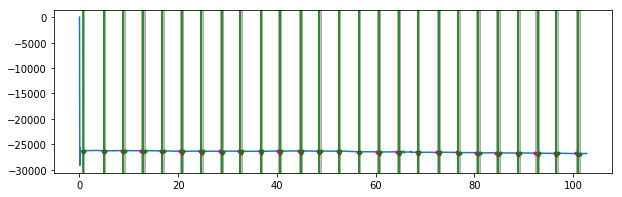

In [2]:
import os
import numpy as np
from scipy.signal import *
import matplotlib
#get_ipython().magic(u'matplotlib notebook')
import matplotlib.pyplot as plt
import csv

from scipy.interpolate import interp1d

mode = True # mode True means EEG-IO, otherwise v/r (EEG-VV or EEG-VR) data
data_path = 'data/EEG-IO' if mode else 'data/EEG-VV' # or replace w/ EEG-VR
file_idx = 7

fs = 250.0
chan_id = 1

flag_soft = True # if True, consider soft blinks as ground truth

blink_len_max = 2.0 # in seconds
blink_len_min = 0.2 # in seconds


delta_init = 100 # in uvolts

corr_threshold_1 = 0.2
corr_threshold_2 = 0.7

std_threshold_window = int(5*fs)  #%  in seconds - for each direction


# function to bandpass filter
def lowpass(sig, fc, fs, butter_filt_order):
    B,A = butter(butter_filt_order, np.array(fc)/(fs/2), btype='low')
    return lfilter(B, A, sig, axis=0)

def decode_stim(data_path, file_stim):
    interval_corrupt = []
    blinks = []
    n_corrupt = 0
    with open(os.path.join(data_path,file_stim)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0]=="corrupt":
                n_corrupt = int(row[1])
            elif n_corrupt > 0:
                if float(row[1]) == -1:
                    t_end = data_sig[-1,0]
                else:
                    t_end = float(row[1])
                interval_corrupt.append([float(row[0]), t_end])
                n_corrupt = n_corrupt - 1
            elif row[0]=="blinks":
                if not n_corrupt==0:
                    print("!Error in parsing")
            else:
                blinks.append([float(row[0]), int(row[1])])
    blinks = np.array(blinks)

    return interval_corrupt, blinks 


# Reading data files
list_of_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and '_data' in f]

file_sig = list_of_files[file_idx]
file_stim = list_of_files[file_idx].replace('_data','_labels')
print("File Name: ", file_sig, file_stim)


# Loading Data
if mode:
    data_sig = np.loadtxt(open(os.path.join(data_path,file_sig), "rb"), delimiter=";", skiprows=1, usecols=(0,1,2))
else:
    data_sig = np.loadtxt(open(os.path.join(data_path,file_sig), "rb"), delimiter=",", skiprows=5, usecols=(0,1,2))
    data_sig = data_sig[0:(int(200*fs)+1),:]
    data_sig = data_sig[:,0:3]
    data_sig[:,0] = np.array(range(0,len(data_sig)))/fs

# Step1: Low Pass Filter
data_sig[:,1] = lowpass(data_sig[:,1], 10, fs, 4)
data_sig[:,2] = lowpass(data_sig[:,2], 10, fs, 4)

time_min = data_sig[0,0]
time_max = data_sig[-1,0]

data_len = len(data_sig)


# decoding stimulations
interval_corrupt, gt_blinks = decode_stim(data_path, file_stim)

def compute_running_std(data_sig, chan_id, fs):
    # Find running std
    std_length = int(0.5*fs) # in seconds
    

    running_std = np.zeros([data_len,1])
    idx = 0
    while(idx < len(data_sig) - std_length):
        running_std[idx] = np.std(data_sig[idx:(idx + std_length), chan_id])
        idx = idx + 1
    running_std[idx:-1] = running_std[idx-1]

    # fixing the corrupted signal's std
    for idx in range(data_len):
        if running_std[idx] < 1:
            l_index_lhs = max(0,idx-std_length)
            l_index_rhs = max(0,(idx-std_length-2*std_threshold_window-int(fs)))
            r_index_lhs = min(data_len, idx+std_length)
            r_index_rhs = max(0,idx-std_length-int(fs))
            running_std[l_index_lhs:r_index_lhs] = min(running_std[l_index_rhs:r_index_rhs])
            idx=idx+std_length-1
            
    return running_std

# Function to find peaks

def args_init(delta_uV):
    args = {}
    args['mintab'], args['maxtab'] = [], []
    args['mn'], args['mx'] = float("inf"), -1*float("inf")
    args['mnpos'], args['mxpos'] = None, None
    args['min_left'], args['min_right'] = [], []
    args['lookformax'] = True
    args['delta'] = delta_uV
    return args


def peakdet(time, value, args):
    foundMin = False
    if value > args['mx']:
        args['mx'] = value
        args['mxpos'] = time
    if value < args['mn']:
        args['mn'] = value
        args['mnpos'] = time
    if args['lookformax']:
        if value < args['mx'] - args['delta']:
            args['maxtab'].append([args['mxpos'], args['mx']])
            args['mn'] = value
            args['mnpos'] = time
            args['lookformax'] = False
    else:
        if value > args['mn'] + args['delta']:
            args['mintab'].append([args['mnpos'], args['mn']])
            args['min_left'].append([-1, -1])
            args['min_right'].append([-1, -1])
            args['mx'] = value
            args['mxpos'] = time
            args['lookformax'] = True                
            foundMin = True
    return foundMin
    
## Finding extreme points

def find_expoints(stat_min2, data_sig, chan_id):
    # Parameters
    offset_t = 0.00 # in seconds
    win_size = 25
    win_offset = 10
    search_maxlen_t = 1.5 # in seconds


    offset_f = int(offset_t*fs)
    search_maxlen_f = int(search_maxlen_t*fs)
    iters = int(search_maxlen_f/win_offset)

    data_len = len(data_sig)
    p_blinks_t, p_blinks_val = [], []
    for idx in range(len(stat_min2)):
        # x_indR and x_indL are starting points for left and right window
        x_indR = int(fs*stat_min2[idx,0]) + offset_f
        x_indL = int(fs*stat_min2[idx,0]) - offset_f
        start_index = max(0, int(fs*stat_min2[idx,0]) - std_threshold_window)
        end_index = min( int(fs*stat_min2[idx,0]) + std_threshold_window, data_len)
        stable_threshold = 2*min(running_std[start_index:end_index])
        min_val = stat_min2[idx,1];
        max_val = min_val;
        found1, found2 = 0, 0
        state1, state2 = 0, 0

        for iter in range(iters):
            if(x_indR + win_size > data_len):
                x_indR = x_indR - (x_indR + win_size - data_len)
            if(x_indL < 0):
                x_indL = 0
            if (np.std(data_sig[x_indR:x_indR+win_size, chan_id]) < stable_threshold) and state1==1 and data_sig[x_indR, chan_id]>min_val:
                found1 = 1
                max_val = max(data_sig[x_indR, chan_id],max_val)
            if (np.std(data_sig[x_indL:x_indL+win_size, chan_id]) < stable_threshold) and state2==1 and data_sig[x_indL + win_size, chan_id]>min_val:
                found2 = 1
                max_val = max(data_sig[x_indL + win_size, chan_id],max_val)
            if (np.std(data_sig[x_indR:x_indR+win_size, chan_id]) > 2.5*stable_threshold) and state1==0:
                state1 = 1
            if (np.std(data_sig[x_indL:x_indL+win_size, chan_id]) > 2.5*stable_threshold) and state2==0:
                state2 = 1
            if (found1==1) and data_sig[x_indR, chan_id] < (max_val + 2*min_val)/3:
                found1=0
            if (found2==1) and data_sig[x_indL + win_size, chan_id] < (max_val + 2*min_val)/3:
                found2=0
            if (found1==0):
                x_indR = x_indR + win_offset
            if (found2==0):
                x_indL = x_indL - win_offset;
            if found1==1 and found2==1:
                break
        if found1==1 and found2==1:
            if (x_indL + win_size)/fs > stat_min2[idx,0]:
                p_blinks_t.append([(x_indL)/fs, stat_min2[idx,0], x_indR/fs])
                p_blinks_val.append([data_sig[x_indL, chan_id], stat_min2[idx,1], data_sig[x_indR,chan_id]])         
            else:
                p_blinks_t.append([(x_indL + win_size)/fs, stat_min2[idx,0], x_indR/fs])
                p_blinks_val.append([data_sig[x_indL + win_size, chan_id], stat_min2[idx,1], data_sig[x_indR,chan_id]])
            

    p_blinks_t = np.array(p_blinks_t)        
    p_blinks_val = np.array(p_blinks_val)  
    
    return p_blinks_t, p_blinks_val

def compute_correlation(p_blinks_t, data_sig, chan_id, fs):
    total_p_blinks = len(p_blinks_t)
    corr_matrix = np.ones([total_p_blinks, total_p_blinks])
    pow_matrix = np.ones([total_p_blinks, total_p_blinks])
    for idx_i in range(total_p_blinks):
        for idx_j in range(idx_i+1,total_p_blinks):

            blink_i_left = data_sig[int(fs*p_blinks_t[idx_i,0]):int(fs*p_blinks_t[idx_i,1]), chan_id]
            blink_i_right = data_sig[int(fs*p_blinks_t[idx_i,1]):int(fs*p_blinks_t[idx_i,2]), chan_id]

            blink_j_left = data_sig[int(fs*p_blinks_t[idx_j,0]):int(fs*p_blinks_t[idx_j,1]), chan_id]
            blink_j_right = data_sig[int(fs*p_blinks_t[idx_j,1]):int(fs*p_blinks_t[idx_j,2]), chan_id]

            left_interp = interp1d(np.arange(blink_i_left.size), blink_i_left)
            compress_left = left_interp(np.linspace(0,blink_i_left.size-1, blink_j_left.size))
            right_interp = interp1d(np.arange(blink_i_right.size), blink_i_right)
            compress_right = right_interp(np.linspace(0,blink_i_right.size-1, blink_j_right.size))

            sigA = np.concatenate((compress_left, compress_right))
            sigB = np.concatenate((blink_j_left, blink_j_right))
            
            corr = np.corrcoef(sigA, sigB)[0,1]
            corr_matrix[idx_i, idx_j] = corr
            corr_matrix[idx_j, idx_i] = corr
            
            if np.std(sigA) > np.std(sigB):
                pow_ratio = np.std(sigA)/np.std(sigB)
            else:
                pow_ratio = np.std(sigB)/np.std(sigA)
            
            pow_matrix[idx_i, idx_j] = pow_ratio
            pow_matrix[idx_j, idx_i] = pow_ratio
            

    return corr_matrix, pow_matrix

args_chan1 = args_init(delta_init)

running_std = compute_running_std(data_sig, chan_id, fs)
for idx in range(len(data_sig[:,0])):
    peakdet(data_sig[idx,0], data_sig[idx, chan_id], args_chan1)

min_pts = np.array(args_chan1['mintab'])
p_blinks_t, p_blinks_val = find_expoints(min_pts, data_sig, chan_id)
corr_matrix, pow_matrix = compute_correlation(p_blinks_t, data_sig, chan_id, fs)

       
# fingerprint
blink_fp_idx = np.argmax(sum(corr_matrix))
t = corr_matrix[blink_fp_idx,:] > corr_threshold_1
blink_index = [i for i, x in enumerate(t) if x]

blink_template_corrmat = corr_matrix[np.ix_(blink_index,blink_index)]
blink_template_powmat = pow_matrix[np.ix_(blink_index,blink_index)]
blink_templates_corrWpower = blink_template_corrmat/blink_template_powmat

blink_var = []
for idx in blink_index:
    blink_var.append(np.var(data_sig[int(fs*p_blinks_t[idx,0]):int(fs*p_blinks_t[idx,2]), chan_id]))

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

Z = linkage(blink_templates_corrWpower, 'complete', 'correlation')
groups = fcluster(Z,2,'maxclust')

grp_1_blinks_var = [blink_var[i] for i, x in enumerate(groups==1) if x]
grp_2_blinks_var = [blink_var[i] for i, x in enumerate(groups==2) if x]
if np.mean(grp_1_blinks_var) > np.mean(grp_2_blinks_var):
    selected_group = 1
else:
    selected_group = 2
template_blink_idx = [blink_index[i] for i, x in enumerate(groups==selected_group) if x]

# computing delta new
delta_new = 0
for idx in template_blink_idx:
    delta_new = delta_new + min(p_blinks_val[idx,0], p_blinks_val[idx,2]) - p_blinks_val[idx,1]
delta_new = delta_new/len(template_blink_idx)

# 2nd pass

args_chan1 = args_init(delta_new/3.0)

for idx in range(len(data_sig[:,0])):
    peakdet(data_sig[idx,0], data_sig[idx, chan_id], args_chan1)

min_pts = np.array(args_chan1['mintab'])
p_blinks_t, p_blinks_val = find_expoints(min_pts, data_sig, chan_id)
corr_matrix, pow_matrix = compute_correlation(p_blinks_t, data_sig, chan_id, fs)

       
s_fc = (sum(corr_matrix))
sort_idx = sorted(range(len(s_fc)), key=lambda k: s_fc[k])

t = corr_matrix[sort_idx[-1],:] > corr_threshold_2        
blink_index1 = set([i for i, x in enumerate(t) if x])
t = corr_matrix[sort_idx[-2],:] > corr_threshold_2        
blink_index2 = set([i for i, x in enumerate(t) if x])
t = corr_matrix[sort_idx[-3],:] > corr_threshold_2        
blink_index3 = set([i for i, x in enumerate(t) if x])

blink_index = list(blink_index1.union(blink_index2).union(blink_index3))

blink_template_corrmat = corr_matrix[np.ix_(blink_index,blink_index)]
blink_template_powmat = pow_matrix[np.ix_(blink_index,blink_index)]
blink_templates_corrWpower = blink_template_corrmat/blink_template_powmat

blink_var = []
for idx in blink_index:
    blink_var.append(np.var(data_sig[int(fs*p_blinks_t[idx,0]):int(fs*p_blinks_t[idx,2]), chan_id]))


Z = linkage(blink_templates_corrWpower, 'complete', 'correlation')
groups = fcluster(Z,2,'maxclust')

grp_1_blinks_var = [blink_var[i] for i, x in enumerate(groups==1) if x]
grp_2_blinks_var = [blink_var[i] for i, x in enumerate(groups==2) if x]

if np.mean(grp_1_blinks_var) > np.mean(grp_2_blinks_var) and np.mean(grp_1_blinks_var)/np.mean(grp_2_blinks_var) > 10:
    blink_index = [blink_index[i] for i, x in enumerate(groups==1) if x]
elif np.mean(grp_2_blinks_var) > np.mean(grp_1_blinks_var) and np.mean(grp_2_blinks_var)/np.mean(grp_1_blinks_var) > 10:
    blink_index = [blink_index[i] for i, x in enumerate(groups==2) if x]

final_blinks_t = p_blinks_t[blink_index,:]
final_blinks_val = p_blinks_val[blink_index,:]

#print "Final Blinks:"
#print final_blinks_t


plt.rcParams["figure.figsize"] = (10,3)
fig, ax1 = plt.subplots()

ax1.plot(data_sig[:,0], data_sig[:,chan_id])

plt.plot(final_blinks_t[:,1], final_blinks_val[:,1],'r.')
plt.plot(final_blinks_t[:,0], final_blinks_val[:,0],'m.')
plt.plot(final_blinks_t[:,2], final_blinks_val[:,2],'g.')

for idx, d in enumerate(final_blinks_t):
    ax1.axvspan(d[0], d[2], alpha=0.5, color='tab:gray')
    
for i in interval_corrupt:
    ax1.axvspan(i[0], i[1], alpha=0.5, color='red')
    
for d in gt_blinks:
    if d[1] < 2:
        plt.axvline(x=d[0], color='green')
    elif d[1] == 2:
        plt.axvline(x=d[0], color='black')

pred = []
for blink_intervals in final_blinks_t:
    blink_start, blink_end = blink_intervals[0], blink_intervals[2]
    flag = False
    for corrupt_interval in interval_corrupt:
        corrupt_start = corrupt_interval[0]
        corrupt_end = corrupt_interval[1]

        # See if there is any intersection
        if (corrupt_end > blink_start) and (corrupt_start < blink_end):
            flag = True
            
    if flag is False and flag_soft is False:
        for idx, d in enumerate(gt_blinks):
            if d[1]==2:# i.e. soft blink
                if d[0] < blink_end and d[0] > blink_start:
                    flag = True
        for idx, d in enumerate(gt_blinks):
            if d[1]<2:# i.e. soft blink
                if d[0] < blink_end and d[0] > blink_start:
                    flag = False
                    
    if flag is False:
        pred.append(blink_intervals)

if flag_soft:
    ground_truth = gt_blinks[:,0]
else:
    ground_truth = [item[0] for item in gt_blinks if item[1]<2]
if mode is False: # i.e. video/read dataset
        # consider stimulations till 200s
        ground_truth = [item for item in ground_truth if item < 199.5]

pred =  np.array(pred)
ground_truth =  np.array(ground_truth)

cmat = np.array([[0,0],[0,0]])

total_pred =  len(pred)
total_gt = len(gt_blinks)

for gt_sample in ground_truth:
    found = False
    for pred_sample in pred:
        blink_start, blink_end = pred_sample[0], pred_sample[2]
        if gt_sample > blink_start and gt_sample < blink_end:
            found = True
    if found:
        cmat[0,0] = cmat[0,0] + 1
    else:
        cmat[1,0] = cmat[1,0] + 1
        #print gt_sample

for pred_sample in pred:
    blink_start, blink_end = pred_sample[0], pred_sample[2]
    found = False
    for gt_sample in ground_truth:        
        if gt_sample > blink_start and gt_sample < blink_end:
            found = True
    if found:
        cmat[1,1] = cmat[1,1] + 1
    else:
        cmat[0,1] = cmat[0,1] + 1

print("Confusion Matrix:")     
print(cmat)

precision = cmat[0,0]*1.0/(cmat[0,0] + cmat[0,1])
recall = cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0])
f1 = 2*precision*recall/(precision+recall)

print("Recall, Precision, F1 Score")
print(recall, precision, f1)

plt.show
